In [7]:
import pytest
import pandas as pd
import sqlite3
import numbers
import networkx as nx
from collections import defaultdict 
from collections.abc import Iterable
import operator

%matplotlib inline

In [86]:
def conduct_sql_query(db, query):
    #Conducts SQL query and returns results as DataFrame.
    conn = sqlite3.connect(db)
    c = conn.cursor()
    c.execute(query)
    results = c.fetchall()
    df = pd.DataFrame(results)
    df.columns = [i[0] for i in c.description]
    conn.close()
    return df

def find_source_nodes(db, table, wikidata_id_list):
    #Find all triplets that contain a node in wikidata_id_list as source.
    #Returns dictionary where key is source node and value is list of tuples
    #First item of tuple is source node, second is the edge property, and third item is target node.
    query = '''
            SELECT 
                source_item_id, edge_property_id, target_item_id 
            FROM 
                {} 
            WHERE 
                source_item_id IN {} 
            ;
            '''.format(table, tuple(wikidata_id_list))
    query_results = conduct_sql_query(db, query)
    source_dict = defaultdict(list, {})
    query_results.apply(lambda row:
                    source_dict[row['source_item_id']].append(tuple(row)), 
                    axis = 1)
    return source_dict
    
def find_target_nodes(db, table, wikidata_id_list):
    #Find all triplets that contain a node in wikidata_id_list as target.
    #Returns dictionary where key is target node and value is list of tuples
    #First item of tuple is source node, second is the edge property, and third item is source node.
    query = '''
            SELECT 
                source_item_id, edge_property_id, target_item_id 
            FROM 
                {} 
            WHERE 
                target_item_id IN {}
            ;
            '''.format(table, tuple(wikidata_id_list))
    query_results = conduct_sql_query(db, query)
    target_dict = defaultdict(list, {})
    query_results.apply(lambda row:
                    target_dict[row['target_item_id']].append(tuple(row)), 
                    axis = 1)
    return target_dict

def construct_subKG(db, table, wikidata_id_list, direct_relations = False):
    #Constructs subKG from table of triplets where source and/or target are in wikidata_id_list
    #When direct_relations is True, both source and target are in wikidata_id_list
    #Else only one need to be in wikidata_id_list
    #Return list containing two dictionaries
    #First dictionary contains source as key and list of (source, edge, target) as item
    #Second dictionary contains target as key and list of (source, edge, target) as item
    and_or = 'OR'
    if direct_relations:
         and_or = 'AND'
    query = '''
            SELECT 
                source_item_id, edge_property_id, target_item_id 
            FROM 
                {} 
            WHERE 
                target_item_id IN {}
                {} source_item_id iN {}
            ;
            '''.format(table, tuple(wikidata_id_list), and_or, tuple(wikidata_id_list))
    query_results = conduct_sql_query(db, query)
    source_dict = defaultdict(list, {})
    target_dict = defaultdict(list, {})
    query_results.apply(lambda row:
                    (source_dict[row['source_item_id']].append(tuple(row)), 
                    target_dict[row['target_item_id']].append(tuple(row))), 
                    axis = 1)
    return source_dict, target_dict

def degree(graph_dict, nodes = "all"):
    #Calculates the degrees of nodes in graph_dict
    #graph_dict shuld be a default dict with default item being empty list, 
        #with key being the node and value being the list of (source, edge, target) it is involved in.
    #If nodes = 'all', then get degree of all nodes in graph_dict and return as dictionary with key being the node
    #If nodes is a number, then get degree of that node
    #If nodes is an iterable, then get degree of each node in nodes and return as dictionary with key being the node
    #Note that if graph_dict does not contain the node, degree will be 0
    degree_dict = {}
    if nodes == "all":
        for key, value in graph_dict.items():
            degree_dict[key] = len(value)
        return degree_dict
    elif isinstance(nodes, numbers.Number):
        return len(graph_dict[nodes])
    elif isinstance(nodes, Iterable) and not isinstance(nodes, str):
        for node in nodes:
            degree_dict[node] = len(graph_dict[node])
        return degree_dict
    else:
        raise Exception("Invalid nodes argument!")
        
def convert_graph_dict_to_nx_graph(graph_dict, directed = False):
    #Converts graph_dict to a networkx graph object
    #graph_dict shuld be a default dict with default item being empty list, 
        #with key being the node and value being the list of (source, edge, target) it is involved in.
    #If directed = True, graph dict represents a directed graph
    graph = nx.Graph()
    if directed:
        graph = nx.DiGraph()
    for triplet in sum(graph_dict.values(), []):
        source, edge, target = triplet
        graph.add_node(source)
        graph.add_node(target)
        graph.add_edge(source, target, type_of_edge = edge)
    return graph

def shortest_path(graph_dict, source_node, target_node, directed = False):
    #Calculates shortest path between source node and target node and returns path as list
    #graph_dict shuld be a default dict with default item being empty list, 
        #with key being the node and value being the list of (source, edge, target) it is involved in.
    #If directed = True, graph dict represents a directed graph
    #If there is no path, return None
    graph = convert_graph_dict_to_nx_graph(graph_dict, directed)
    try:
        shortest = nx.shortest_path(graph, source_node, target_node)
    except nx.NetworkXNoPath:
        shortest = None
    return shortest

def indegree_centrality(graph_dict, directed = False):
    graph = convert_graph_dict_to_nx_graph(graph_dict, directed)
    return defaultdict(lambda: 0, nx.in_degree_centrality(graph))

def outdegree_centrality(graph_dict, directed = False):
    graph = convert_graph_dict_to_nx_graph(graph_dict, directed)
    return defaultdict(lambda: 0, nx.out_degree_centrality(graph))

def betweenness_centrality(graph_dict, directed = False):
    graph = convert_graph_dict_to_nx_graph(graph_dict, directed)
    return defaultdict(lambda: 0, nx.betweenness_centrality(graph))

def eigenvector_centrality(graph_dict, directed = False):
    #Still need to read more about this. Eigenvector centrality is usually only good for non-directed graph
    graph = convert_graph_dict_to_nx_graph(graph_dict, directed)
    return defaultdict(lambda: 0, nx.eigenvector_centrality(graph, max_iter = 1000))

def closeness_centrality(graph_dict, directed = False):
    graph = convert_graph_dict_to_nx_graph(graph_dict, directed)
    return defaultdict(lambda: 0, nx.closeness_centrality(graph))

https://www.geeksforgeeks.org/generate-graph-using-dictionary-python/

In [13]:
db = 'test.db'
table = 'test_table'

conn = sqlite3.connect(db)
test_example = [[10, 'producer of', 30], [10, 'headquartered in', 50], [40, 'exporter of', 20], [30, 'manufactured in', 40]]
test_example = pd.DataFrame(test_example, columns = ['source_item_id', 'edge_property_id', 'target_item_id'])
test_example.to_sql(table, conn, if_exists = 'replace')
conn.commit()
conn.close()

def test_find_source_nodes():
    source_nodes = {
        10: [(10, "producer of", 30), (10, "headquartered in", 50)],
        30: [(30, "manufactured in", 40)],
        40: [(40, "exporter of", 20)]
    }
    source_nodes = defaultdict(list, source_nodes)
    wikidata_id_list = [10, 20, 30, 40, 50]
    found_source_nodes = find_source_nodes(db, table, wikidata_id_list)
    for wikidata_id in wikidata_id_list:
        assert len(source_nodes[wikidata_id]) == len(found_source_nodes[wikidata_id])
        assert set(source_nodes[wikidata_id]) == set(found_source_nodes[wikidata_id])

def test_find_target_nodes():
    target_nodes = {
        30: [(10, "producer of", 30)],
        20: [(40, "exporter of", 20)],
        40: [(30, "manufactured in", 40)],
        50: [(10, "headquartered in", 50)]
    }
    target_nodes = defaultdict(list, target_nodes)
    wikidata_id_list = [10, 20, 30, 40, 50]
    found_target_nodes = find_target_nodes(db, table, wikidata_id_list)
    for wikidata_id in wikidata_id_list:
        assert len(target_nodes[wikidata_id]) == len(found_target_nodes[wikidata_id])
        assert set(target_nodes[wikidata_id]) == set(found_target_nodes[wikidata_id])
    
def test_construct_subKG():
    relevant_wikidata_id_list = [10, 20, 30]
    source_nodes = {
        10: [(10, "producer of", 30)] 
    }
    target_nodes = {
        30: [(10, "producer of", 30)]
    }
    source_nodes = defaultdict(list, source_nodes)
    target_nodes = defaultdict(list, target_nodes)
    constructed_subKG = construct_subKG(db, table, relevant_wikidata_id_list, True)
    for wikidata_id in relevant_wikidata_id_list:
        assert len(source_nodes[wikidata_id]) == len(constructed_subKG[0][wikidata_id])
        assert len(target_nodes[wikidata_id]) == len(constructed_subKG[1][wikidata_id])
        assert set(source_nodes[wikidata_id]) == set(constructed_subKG[0][wikidata_id]) 
        assert set(target_nodes[wikidata_id]) == set(constructed_subKG[1][wikidata_id])
        
    source_nodes = {
        10: [(10, "producer of", 30), (10, "headquartered in", 50)],
        30: [(30, "manufactured in", 40)],
        40: [(40, "exporter of", 20)]
    }
    
    target_nodes = {
        30: [(10, "producer of", 30)],
        20: [(40, "exporter of", 20)],
        40: [(30, "manufactured in", 40)],
        50: [(10, "headquartered in", 50)]
    }
    source_nodes = defaultdict(list, source_nodes)
    target_nodes = defaultdict(list, target_nodes)
    constructed_subKG = construct_subKG(db, table, relevant_wikidata_id_list, False)
    for wikidata_id in relevant_wikidata_id_list:
        assert len(source_nodes[wikidata_id]) == len(constructed_subKG[0][wikidata_id])
        assert len(target_nodes[wikidata_id]) == len(constructed_subKG[1][wikidata_id])
        assert set(source_nodes[wikidata_id]) == set(constructed_subKG[0][wikidata_id]) 
        assert set(target_nodes[wikidata_id]) == set(constructed_subKG[1][wikidata_id])
        
def test_degree():
    source_nodes = {
        10: [(10, "producer of", 30), (10, "headquartered in", 50)],
        30: [(30, "manufactured in", 40)],
        40: [(40, "exporter of", 20)]
    }
    source_nodes = defaultdict(list, source_nodes)
    assert degree(source_nodes, 10) == 2
    assert degree(source_nodes, 30) == 1
    assert degree(source_nodes, 40) == 1  
    assert degree(source_nodes, 20) == 0
    assert degree(source_nodes)[10] == 2
    assert degree(source_nodes)[30] == 1
    assert degree(source_nodes)[40] == 1
    with pytest.raises(Exception):
        degree(source_nodes, "10")
    with pytest.raises(Exception):
        degree(source_nodes, None)    
    relevant_wikidata_id_list = [10, 20, 30]
    constructed_subKG = construct_subKG(db, table, relevant_wikidata_id_list, True)   
    apple_wikidata_id_list = [10, 20]
    outdegree = degree(constructed_subKG[0], apple_wikidata_id_list)
    assert outdegree[10] == 1
    assert outdegree[20] == 0
    #Should raise KeyError since didn't ask for degree of 30 in argument
    with pytest.raises(KeyError):
        outdegree[30]
    indegree = degree(constructed_subKG[1], apple_wikidata_id_list)
    assert indegree[10] == 0
    assert indegree[20] == 0
    assert degree(constructed_subKG[1], 30) == 1
    
def test_shortest_path():
    source_nodes = {
        10: [(10, "producer of", 30), (10, "headquartered in", 50)],
        30: [(30, "manufactured in", 40)],
        40: [(40, "exporter of", 20)]
    }
    print(shortest_path(source_nodes, 10, 30, True))
    assert len(shortest_path(source_nodes, 10, 30, True)) == 2
    assert len(shortest_path(source_nodes, 10, 30, False)) == 2
    assert len(shortest_path(source_nodes, 10, 50, True)) == 2
    assert len(shortest_path(source_nodes, 10, 50, False)) == 2
    assert shortest_path(source_nodes, 50, 10, True) is None
    assert len(shortest_path(source_nodes, 50, 10, False)) == 2
    assert len(shortest_path(source_nodes, 10, 40, True)) == 3
    assert shortest_path(source_nodes, 40, 10, True) is None
    assert len(shortest_path(source_nodes, 10, 20, True)) == 4


In [90]:
def baseline_nel(db, table, text, entity_id_dict):
    wikidata_id_list = sum(entity_id_dict.values(), [])
    source_graph, target_graph = construct_subKG(db, table, wikidata_id_list, True)
    best_entity_dict = {}
    indegree_dict = indegree_centrality(source_graph, True)
    outdegree_dict = outdegree_centrality(source_graph, True)
    centrality_dict = {k:indegree_dict[k] + outdegree_dict[k] for k in wikidata_id_list}
    for entity, wikidata_ids in entity_id_dict.items():
        relevant_dict = defaultdict(lambda: 0, {k:v for k,v in centrality_dict.items() if k in wikidata_ids})
        best_entity = max(relevant_dict.items(), key=operator.itemgetter(1))[0]
        best_entity_dict[entity] = best_entity
    return best_entity_dict
        
    
def extract(db, table, text, entity_id_dict):
    wikidata_id_list = sum(entity_id_dict.values(), [])
    source_graph, target_graph = construct_subKG(db, table, wikidata_id_list, True)
    triples_dict = defaultdict(list, {})
    for entity in entity_id_dict.keys():
        wikidata_ids = entity_id_dict[entity]
        for wikidata_id in wikidata_ids:
            triples_dict[entity] += source_graph[wikidata_id]
            triples_dict[entity] += target_graph[wikidata_id]
    return (text, triples_dict)

In [91]:
baseline_nel(db, table, "hello", entity_id_dict = {
    "apple": [10, 20],
    "macbook": [30]
})

{'apple': 10, 'macbook': 30}

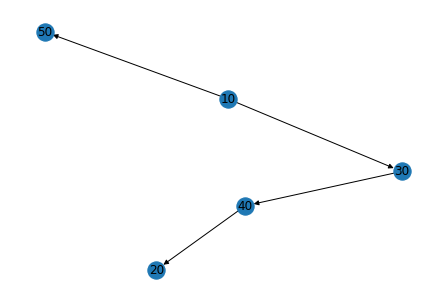

In [55]:
example_kg = construct_subKG(db, table, [10, 20, 30, 40, 50], direct_relations = False)
example_kg = convert_graph_dict_to_nx_graph(example_kg[0], directed = True)

pos = nx.spring_layout(example_kg)
nx.draw_spring(example_kg, with_labels = True)
# edge_labels = nx.get_edge_attributes(example_kg,'type_of_edge')
# nx.draw_networkx_edge_labels(example_kg, pos, labels = edge_labels);


In [45]:
nx.eigenvector_centrality(example_kg)

{10: 0.49999999508235293,
 30: 0.5773493802714444,
 50: 0.2886760320285294,
 40: 0.49999999508235293,
 20: 0.2886760320285294}